In [ ]:
!pip install node2vec

In [43]:
import pandas as pd
import networkx as nx, matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score, completeness_score, homogeneity_score
import itertools
from node2vec import Node2Vec
from sklearn.cluster import KMeans
import numpy as np

# Data Set up

In [17]:
########### LASTFM DATASET
# # Download and save the lastfm_asia_edges.csv in the required format
# # Download link: https://snap.stanford.edu/data/feather-lastfm-social.html
# # Data source: 
#     # Author: Benedek Rozemberczki and Rik Sarkar
#     # Title: Characteristic Functions on Graphs: Birds of a Feather, from Statistical Descriptors to Parametric Models
#     # Year: 2020
    
# edges=pd.read_csv(r'data/lastfm_asia/lastfm_asia_edges.csv')
# print(edges)

# # import json
 
# # Opening JSON file
# f = open('data/lastfm_asia/lastfm_asia_features.json')
 
# # returns JSON object as 
# # a dictionary
# nodes = json.load(f)

# nodes=pd.DataFrame.from_dict(nodes, orient='index')
# print(nodes)

# # target=pd.read_csv('lastfm_asia/lastfm_asia_target.csv')
# # target

In [30]:
########### EMAIL DATASET
# https://snap.stanford.edu/data/email-Eu-core.html
# Source:
#     Hao Yin, Austin R. Benson, Jure Leskovec, and David F. Gleich. "Local Higher-order Graph Clustering." In Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. 2017.
#     J. Leskovec, J. Kleinberg and C. Faloutsos. Graph Evolution: Densification and Shrinking Diameters. ACM Transactions on Knowledge Discovery from Data (ACM TKDD), 1(1), 2007.

edges = pd.read_csv(r'data/email_eu/email-Eu-core.txt', sep=' ')
edges = edges.rename(columns={'0':'node_1', '1':'node_2'})

truth = pd.read_csv('data/email_eu/email-Eu-core-department-labels.txt', sep=' ')
truth.columns=['node','label']
print('Total number of ground truth communities:',truth.label.nunique())
display(edges, truth)

Total number of ground truth communities: 42


,node_1,node_2
0,2,3
1,2,4
2,5,6
3,5,7
4,8,9
...,...,...
25565,420,143
25566,174,859
25567,440,460
25568,52,786


,node,label
0,1,1
1,2,21
2,3,21
3,4,21
4,5,25
...,...,...
999,1000,4
1000,1001,21
1001,1002,1
1002,1003,6


In [5]:
########### CONGRESS DATASET
# ## Download and save the congresslist.edgelist in the required format
# ## Download link : https://snap.stanford.edu/data/congress-twitter.html
# ## Data source: C.G. Fink, K. Fullin, G. Gutierrez, N. Omodt, S. Zinnecker, 
# ## G. Sprint, and S. McCulloch: A centrality measure for quantifying spread 
# ## on weighted, directed networks. Physica A, 2023.

# G = nx.read_edgelist('data/congress_network/congress.edgelist')

# transition_G = nx.google_matrix(G)
# transition_G=pd.DataFrame(transition_G)

# # Save to Matrix format in txt (transpose to make it column wise stochastic)
# transition_G.T.to_csv('data/matrix-congress.txt', sep=' ', index=True, header=False)

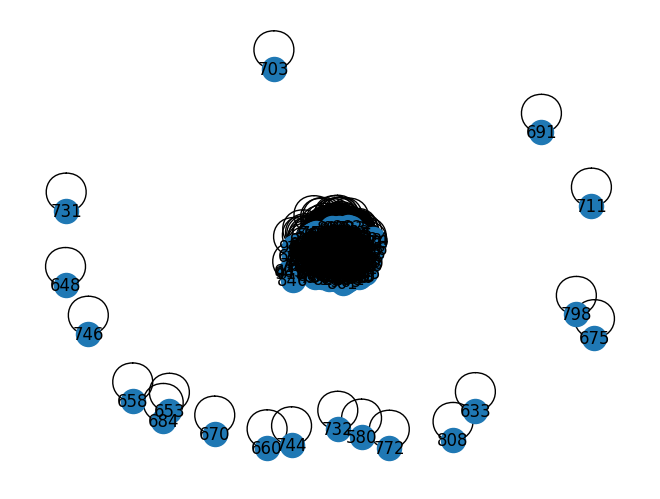

In [31]:
# Create graph
G = nx.from_pandas_edgelist(edges, 'node_1', 'node_2')

# Visualize the graph
nx.draw(G, with_labels=True)
plt.show()

In [32]:
nx.adjacency_matrix(G).shape[1]

/tmp/ipykernel_105501/3460206156.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  nx.adjacency_matrix(G).shape[1]


1005

# Community Detection

## Functions

In [33]:
def graph_community(G, community):
    # Visualize the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)

    # Assign community colors to nodes
    node_colors = []
    for node in G.nodes():
        for i, comm in enumerate(community):
            if node in comm:
                node_colors.append(i)
                break

    # Draw nodes with community colors
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.rainbow)

    # # Optionally, draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.show()

In [34]:
def calculate_ratio_cut(graph, communities):
    total_cut_size = 0
    total_volume = 0

    # Calculate total cut size and total volume
    for community1, community2 in itertools.combinations(communities, 2):
        cut_size = nx.cut_size(graph, community1, community2)
        total_cut_size += cut_size

        volume1 = len(graph.subgraph(community1).edges())
        volume2 = len(graph.subgraph(community2).edges())
        total_volume += min(volume1, volume2)

    # Calculate ratio cut
    ratio_cut_value = total_cut_size / total_volume
    return ratio_cut_value

def convert_list(list_of_sets):
    """
    Helper function to convert a list of sets to a pandas dataframe
    """
    # Create an empty list to store the data
    data = []

    # Iterate through each set in the list, enumerate to get the index
    for i, s in enumerate(list_of_sets):
        # Iterate through each item in the set
        for item in s:
            # Append a tuple containing the index and the item to the data list
            data.append((i, item))

    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['pred_community', 'node']).astype(int)

    return df

def get_metrics(G, community, true_labels=None):
    """
    Arguments:
        G: networkx graph object
        community: list of sets of community assignments 
        true_labels: pandas dataframe of node and ground truth label (column names: ['node','label']). If none, then the adjusted rand index will not be returned.
    
    Returns: dictionary of metrics
    
    More information about the metrics:
    
    1. Modularity:
    Returns the modularity of the given partition of the graph.
    
    2. Partition Quality:
    The coverage of a partition is the ratio of the number of intra-community edges to the total number of edges in the graph.
    The performance of a partition is the number of intra-community edges plus inter-community non-edges divided by the total number of potential edges.
    --> returns (coverage, performance) tuple of the partition

    3. Ratio Cut
    The ratio of the number of edges between nodes in different communities to the total number of edges incident on nodes in the smaller of the two communities
    A lower ratio cut indicates a better partition.
    
    4. Rand index adjusted for chance
    The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and 
    counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
        ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
    The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the 
    number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation). 
    The adjusted Rand index is bounded below by -0.5 for especially discordant clusterings.
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html
    
    5. Homogeneity Score
    A clustering result satisfies homogeneity if all of its clusters contain only data points which are members 
    of a single class.
        0: Non-perfect labelings that further split classes into more clusters can be perfectly homogeneous
        1: Clusters that include samples from different classes do not make for an homogeneous labeling
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
    
    6. Completeness Score
    A clustering result satisfies completeness if all the data points that are members of a given class are 
    elements of the same cluster.
        1: Non-perfect labelings that assign all classes members to the same clusters are still complete
        0: If classes members are split across different clusters, the assignment cannot be complete
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html
        
    """
    # similarity metrics
    
    modularity = nx.algorithms.community.modularity(G, community)
    partion_quality = nx.algorithms.community.partition_quality(G, community) 
    ratio_cut = calculate_ratio_cut(G, community)
    
    output = {'modularity':modularity,
            'partition_quality':partion_quality,
            'ratio_cut': ratio_cut
             }
    
    # Compute rand index if with ground truth labels
    if true_labels is not None:
        check=pd.merge(true_labels, convert_list(community), on='node')
        output['adj_rand_score']=adjusted_rand_score(check.label, check.pred_community)
        output['homogeneity_score']=homogeneity_score(check.label, check.pred_community)
        output['completeness_score']=completeness_score(check.label, check.pred_community)
        
    return output

## Louvain

In [36]:
louvain=nx.community.louvain_communities(G, seed=123)
louvain

[{15,
  45,
  46,
  97,
  98,
  99,
  100,
  101,
  124,
  125,
  139,
  140,
  164,
  185,
  216,
  269,
  272,
  273,
  274,
  300,
  322,
  323,
  334,
  335,
  353,
  354,
  371,
  428,
  429,
  446,
  447,
  448,
  461,
  579,
  592,
  617,
  618,
  638,
  640,
  657,
  662,
  676,
  687,
  708,
  709,
  735,
  760,
  768,
  770,
  794,
  819,
  838,
  891,
  892,
  896,
  929,
  933,
  935,
  937},
 {2,
  3,
  4,
  5,
  6,
  54,
  55,
  56,
  57,
  58,
  59,
  63,
  88,
  89,
  102,
  126,
  131,
  132,
  137,
  138,
  158,
  159,
  174,
  175,
  192,
  193,
  194,
  195,
  208,
  209,
  210,
  211,
  234,
  235,
  236,
  237,
  238,
  239,
  240,
  241,
  242,
  243,
  244,
  252,
  271,
  281,
  285,
  286,
  302,
  303,
  304,
  305,
  319,
  369,
  408,
  411,
  412,
  481,
  516,
  517,
  520,
  528,
  532,
  552,
  564,
  571,
  586,
  587,
  599,
  604,
  610,
  619,
  622,
  625,
  630,
  631,
  634,
  635,
  636,
  637,
  639,
  646,
  665,
  683,
  685,
  698,
  712,
  

In [37]:
# Check created communities
louvain_sum=pd.DataFrame([len(i) for i in louvain], columns=['n_nodes']).reset_index().rename(columns={'index':'community'})
louvain_sum

,community,n_nodes
0,0,59
1,1,143
2,2,94
3,3,68
4,4,139
5,5,1
6,6,121
7,7,1
8,8,1
9,9,1


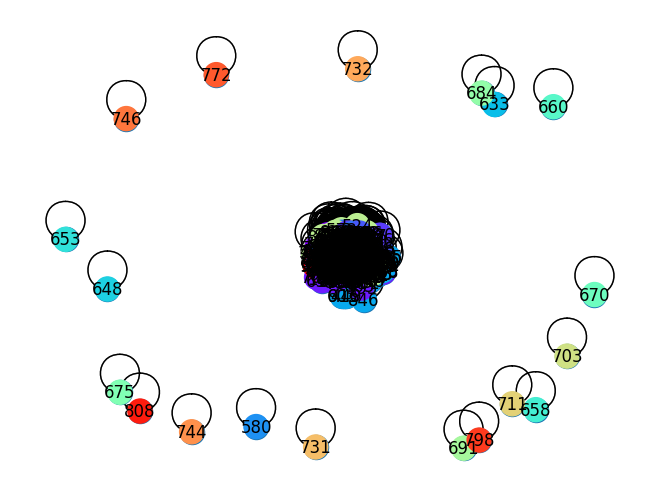

{'modularity': 0.43051577540468683,
 'partition_quality': (0.6001197246333433, 0.8616816316822263),
 'ratio_cut': 0.2847278462128639,
 'adj_rand_score': 0.3384480497698718,
 'homogeneity_score': 0.48835987455469626,
 'completeness_score': 0.7736069035163661}

In [38]:
graph_community(G, community=louvain)
get_metrics(G, louvain, truth)

## Girvan-Newman

In [39]:
G = nx.from_pandas_edgelist(edges, 'node_1', 'node_2')
comp = nx.community.girvan_newman(G)
node_groups = []
for com in next(comp):
    node_groups.append(list(com))
 
print(node_groups)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

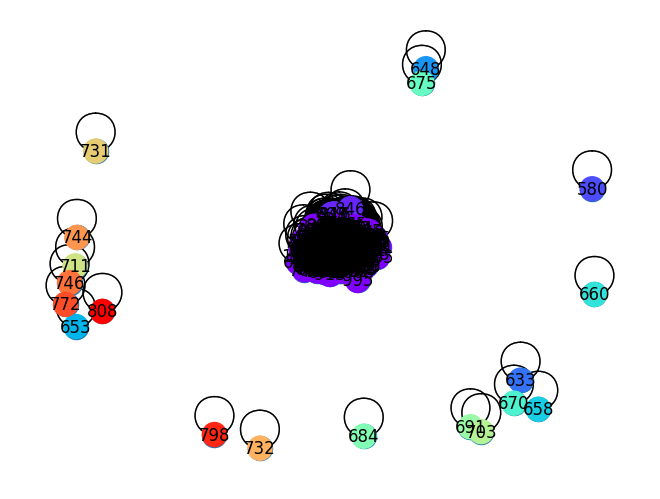

{'modularity': 0.0031091136300904557,
 'partition_quality': (0.9995211014666268, 0.08220649739351053),
 'ratio_cut': 0.037037037037037035,
 'adj_rand_score': -0.000980676645547003,
 'homogeneity_score': 0.022320063118000198,
 'completeness_score': 0.3981751269336859}

In [40]:
graph_community(G, community=node_groups)
get_metrics(G, node_groups, truth)

## k-Clique

In [11]:
cliques = list(nx.community.k_clique_communities(G, 3))
graph_community(G, community=cliques)

: 

In [43]:
get_metrics(G, cliques)

{'modularity': 0.9182888184698955,
 'partition_quality': (1.0, 0.958948651944181),
 'ratio_cut': 0.0}

## Graph Embeddings

In [68]:
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get embeddings for nodes
embeddings = [model.wv[str(node)] for node in G.nodes()]

# Convert embeddings to a NumPy array
X = np.array(embeddings)

# Specify the number of clusters (you may need to adjust this based on your graph)
num_clusters = 15

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

# Assign cluster labels to nodes in the graph
for node, cluster_label in zip(G.nodes(), clusters):
    G.nodes[node]['cluster'] = cluster_label

node_clusters = {}
# Print the cluster assignments
for node, data in G.nodes(data=True):
    if data['cluster'] in node_clusters.keys():
        node_clusters[data['cluster']].append(node)
    
    else:
        node_clusters[data['cluster']] = [node]

Computing transition probabilities:   0%|          | 0/1005 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:28<00:00,  1.74it/s]
/home/koumudi/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f6d01737310>
Traceback (most recent call last):
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home

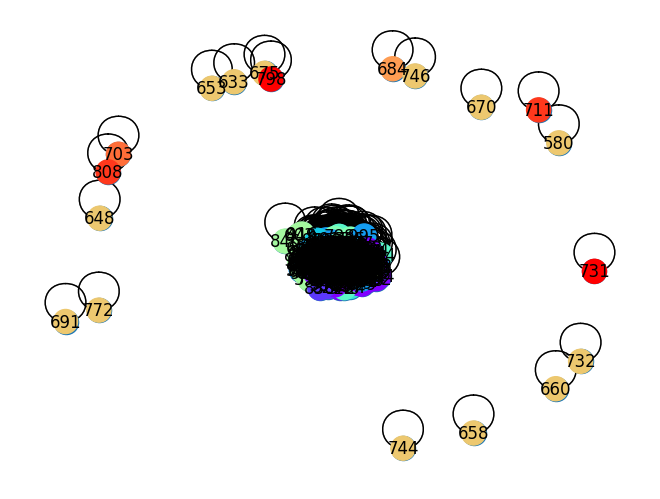

{'modularity': 0.4018295902065179,
 'partition_quality': (0.5587548638132296, 0.8791461021585301),
 'ratio_cut': 0.304649721016739,
 'adj_rand_score': 0.33909339313587095,
 'homogeneity_score': 0.513607552043378,
 'completeness_score': 0.7648673683516644}

In [69]:
graph_community(G, community=node_clusters.values())
get_metrics(G, node_clusters.values(), truth)